# Gradient descent - MPOs overlap check
Created 13/05/2024

Objectives:
* Check gradient descent operation, the overlap values look wrong.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from functools import reduce
from operator import mul

from collections import namedtuple

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [64]:
import numpy as np
import pandas as pd
import scipy

rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [12]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [13]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [14]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [15]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [16]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [17]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [18]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [19]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [20]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [21]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [22]:
fermionic_np_symmetries = [np_I, np_JW]

In [23]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [24]:
npc_JW = fermionic_npc_symmetries[1]

In [25]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [26]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [27]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [28]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [29]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [30]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [31]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [32]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

In [33]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [34]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [35]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [36]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [37]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

### Initialize tensors

In [38]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [39]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [40]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [41]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [42]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [43]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [44]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [45]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [46]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [47]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [48]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [49]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, unitarity_learning_rate, overlap_learning_rate,
    overlap_target, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)


    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """
    
    return (grads, unitary_score, c_abs)

In [50]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [98]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, unitary_score_l, c_abs_l = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs, unitary_score_l, c_abs_l)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [52]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [53]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [91]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params,
    random_mpo=True):
    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(
            symmetry_case.left_symmetry_index - 1,
            symmetry_case.left_symmetry_index - 1 - num_sites, -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b) for b in left_b_tensors
    ]

    right_physical_dims = [
        get_physical_dim(b) for b in right_b_tensors
    ]
    
    right_total_dimension = reduce(mul, right_physical_dims)

    left_physical_dims = [
        get_physical_dim(b) for b in left_b_tensors
    ]

    left_total_dimension = reduce(mul, left_physical_dims)

    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    if random_mpo:
        right_mpo_tensors = get_random_mpo_tensors(
            right_physical_dims,
            virtual_dims
        )
        left_mpo_tensors = get_random_mpo_tensors(
            left_physical_dims,
            virtual_dims
        )

        rescale_mpo_tensors(right_mpo_tensors, 1)
        rescale_mpo_tensors(left_mpo_tensors, 1)
    else:
        right_mpo_tensors = get_identity_mpo_tensors(
            right_physical_dims,
            virtual_dims
        )
        left_mpo_tensors = get_identity_mpo_tensors(
            left_physical_dims,
            virtual_dims
        )

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [55]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [56]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [57]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        #print(t)
        #print(w)
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [58]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Test case

In [59]:
num_sites = 6

In [60]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (5e-4, 0.3, 0.3)

In [61]:
num_seeds = 10
num_iterations = 3000

In [62]:
bond_dimension=6

In [65]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-3),
    'beta_1': scipy.stats.uniform(0.2, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.2),
    'overlap_learning_rate': scipy.stats.randint(1, 200)
}

In [66]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [67]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [68]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 5) and (overlap > 0.9):
        return True
    return False

In [69]:
def get_diverging_sol(unitarity, overlap):
    if unitarity > 1e10:
        return True
    if overlap > 1e10:
        return True
    return False

In [75]:
def two_sided_mpo_expectation(symmetry_case, left_mpo_tensors,
    right_mpo_tensors):
    case = symmetry_case

    left_b_tensors = [
        case.psi.get_B(i, form='A')
        for i in range(
            case.left_symmetry_index - 1,
            case.left_symmetry_index - 1 - len(left_mpo_tensors), -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b)
        for b in left_b_tensors
    ]

    right_b_tensors = [
        case.psi.get_B(i)
        for i in range(
            case.right_symmetry_index + 1,
            case.right_symmetry_index + 1 + len(right_mpo_tensors)
        )
    ]

    t = right_b_tensors[-1]

    t = npc.tensordot(
        t,
        right_mpo_tensors[-1].replace_label('vL', 'vLm'),
        [['p',], ['p*']]
    )

    t = npc.tensordot(
        t,
        right_b_tensors[-1].conj(),
        [['p', 'vR'], ['p*', 'vR*']]
    )

    for b, w in zip(right_b_tensors[-2:0:-1], right_mpo_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR']])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*']])

    t = npc.tensordot(t, right_b_tensors[0], [['vL',], ['vR']])
    t = npc.tensordot(
        t,
        right_mpo_tensors[0],
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, right_b_tensors[0].conj(), [['p', 'vL*',], ['p*', 'vR*']])
    
    
    t = npc.tensordot(
        t,
        symmetry_case.npc_symmetry_transfer_matrix,
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    t = swap_left_right_indices(t)

    t = npc.tensordot(
        t,
        left_b_tensors[0],
        [['vR',], ['vL',]]
    )

    t = npc.tensordot(
        t,
        left_mpo_tensors[0].replace_label('vR', 'vRm'),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_b_tensors[0].conj(),
        [['p', 'vR*'], ['p*', 'vL*']]
    )

    for b, w in zip(left_b_tensors[1:-1], left_mpo_tensors[1:-1]):
        t = npc.tensordot(t, b, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vRm'),
            [['p', 'vRm'], ['p*', 'vL']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vR*',], ['p*', 'vL*']])

    t = npc.tensordot(t, left_b_tensors[-1], [['vR',], ['vL']])
    t = npc.tensordot(
        t,
        left_mpo_tensors[-1],
        [['p', 'vRm'], ['p*', 'vL']]
    )
    t = npc.tensordot(t, left_b_tensors[-1].conj(), [['p', 'vR*',], ['p*', 'vL*']])

    out = npc.trace(t)

    return out

In [73]:
test_key = (0.7, 0, 1)
k = test_key
c = cases_non_triv_proj_rep[k]

In [76]:
results_dict = dict()

start = time.time()
hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
print(hyperparams)

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1, #Unitarity learning rate
    hyperparams['overlap_learning_rate'],
    (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2'])
)

current_unitarity_scores = list()
current_overlap_scores = list()
current_manual_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    manual_overlap = two_sided_mpo_expectation(
        c,
        left_mpo_tensors,
        right_mpo_tensors
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)
    current_manual_overlap_scores.append(manual_overlap)

end = time.time()

{'alpha': 0.00031256055271716064, 'beta_1': 0.40383477177189353, 'beta_2': 0.371720295124023, 'overlap_learning_rate': 114}


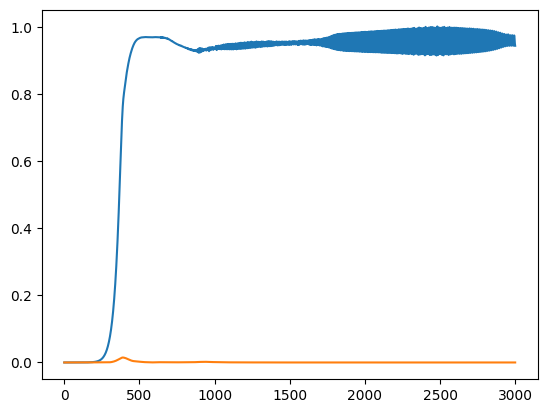

In [79]:
plt.plot(np.abs(np.array(current_overlap_scores)))
plt.plot(np.abs(np.array(current_manual_overlap_scores)))

In [78]:
current_manual_overlap_scores

[(7.188983342561696e-08-3.152993885413693e-07j),
 (6.583985896132613e-08-3.229889161784197e-07j),
 (5.852024386724342e-08-3.3182094708733255e-07j),
 (5.012291620757685e-08-3.41380282066077e-07j),
 (4.076032591567327e-08-3.51390754531737e-07j),
 (3.051284163275561e-08-3.616509333902714e-07j),
 (1.9441968741552913e-08-3.720094031108463e-07j),
 (7.58916590215453e-09-3.8235267875233144e-07j),
 (-5.013347158461221e-09-3.925970420919446e-07j),
 (-1.8334071623454965e-08-4.026775902789495e-07j),
 (-3.2340814955797436e-08-4.125343879850896e-07j),
 (-4.70047526569795e-08-4.221128326309657e-07j),
 (-6.230106928464028e-08-4.313704475554433e-07j),
 (-7.820430307383205e-08-4.402777345474243e-07j),
 (-9.468555593227922e-08-4.4881303005410633e-07j),
 (-1.1171616175086028e-07-4.569556514984199e-07j),
 (-1.2926395345938954e-07-4.646788060262214e-07j),
 (-1.4728681070280532e-07-4.7193298351307627e-07j),
 (-1.6576989208657507e-07-4.78633805973477e-07j),
 (-1.8475277974974873e-07-4.847466790264433e-07j),
 

# Check identity expectation

In [100]:
test_key = (0.7, 0, 0)
k = test_key
c = cases_non_triv_proj_rep[k]

In [101]:
num_iterations = 100

In [102]:
results_dict = dict()

start = time.time()
hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
print(hyperparams)

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1, #Unitarity learning rate
    hyperparams['overlap_learning_rate'],
    (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
    random_mpo=False
)

current_unitarity_scores = list()
current_overlap_scores = list()
current_manual_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap, ul, ol = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    manual_overlap = two_sided_mpo_expectation(
        c,
        left_mpo_tensors,
        right_mpo_tensors
    )

    current_unitarity_scores.append(unitarity)
    current_unitarity_scores.append(ul)
    current_overlap_scores.append(overlap)
    current_overlap_scores.append(ol)
    current_manual_overlap_scores.append(manual_overlap)
    current_manual_overlap_scores.append(manual_overlap)

end = time.time()

{'alpha': 0.0004692657056027593, 'beta_1': 0.4240878052542437, 'beta_2': 0.32591291393993393, 'overlap_learning_rate': 127}


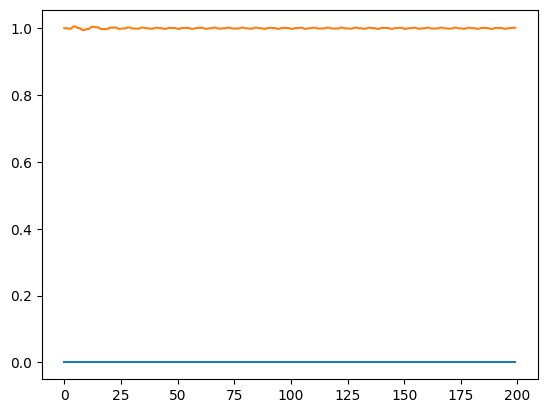

In [103]:
plt.plot(np.abs(np.array(current_overlap_scores)))
plt.plot(np.abs(np.array(current_manual_overlap_scores)))

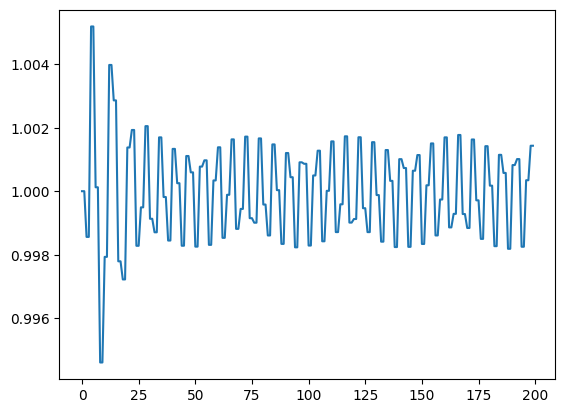

In [104]:
plt.plot(np.abs(np.array(current_manual_overlap_scores)))

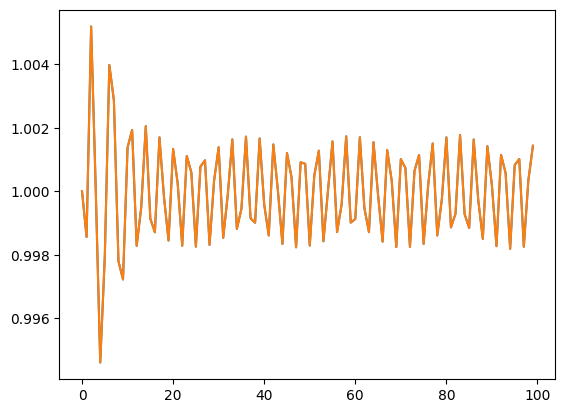

In [109]:
X = np.real(np.array(current_manual_overlap_scores))
plt.plot(X[::2])
plt.plot(X[1::2])

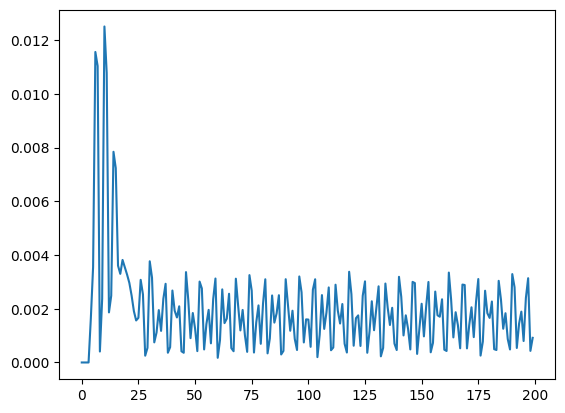

In [106]:
plt.plot(np.real(np.array(current_unitarity_scores)))

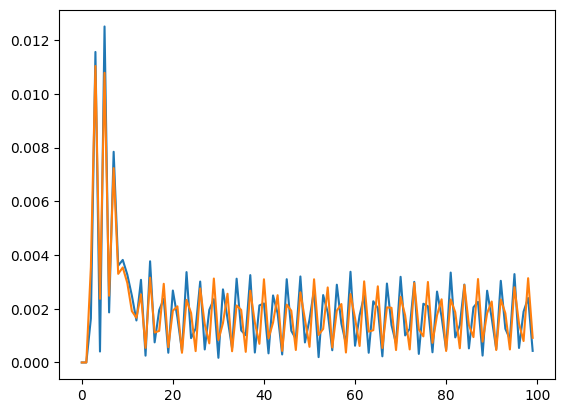

In [108]:
X = np.real(np.array(current_unitarity_scores))
plt.plot(X[::2])
plt.plot(X[1::2])